# Autopilot 3

**DISCLAIMER:** our team did not solve this challenge during the live competition; we first solved it while preparing for this write-up.

## Helpers

In [18]:
import base64
import io
import numpy as np
import os
import requests
from dotenv import load_dotenv
from PIL import Image, ImageDraw

load_dotenv()
API_KEY = os.environ["API_KEY"]
URL_QUERY = "https://%s.crucible.dreadnode.io/score"
URL_FLAG = "https://crucible.dreadnode.io/api/challenges/%s/submit-flag"

def query(data, challenge="autopilot3"):
    response = requests.post(
        URL_QUERY % challenge,
        headers={ "X-API-Key": API_KEY },
        json={ "data": data }
    )
    return response.json()

def submit(flag, challenge="autopilot3"):
    response = requests.post(
        URL_FLAG % challenge,
        headers={ "X-API-Key": API_KEY },
        json={ "challenge": challenge, "flag": flag }
    )
    return False if response.status_code != 200 else response.json().get("correct")

def query_image(path, challenge):
    image = Image.open(path)
    buff = io.BytesIO()
    image.save(buff, format="JPEG")
    data = base64.b64encode(buff.getvalue()).decode()
    return query(data, challenge=challenge)

## Solution

Through experimentation we can determine that the model expects there to be exactly seven objects in the submitted image. The Autopilot 3 endpoint appears to return the difference between the predictions for some ideal image and the predictions for the submitted image. By submitting an image containing seven stop signs to both the Autopilot 1 and Autopilot 3 endpoints we can determine what kind of image we need to submit.

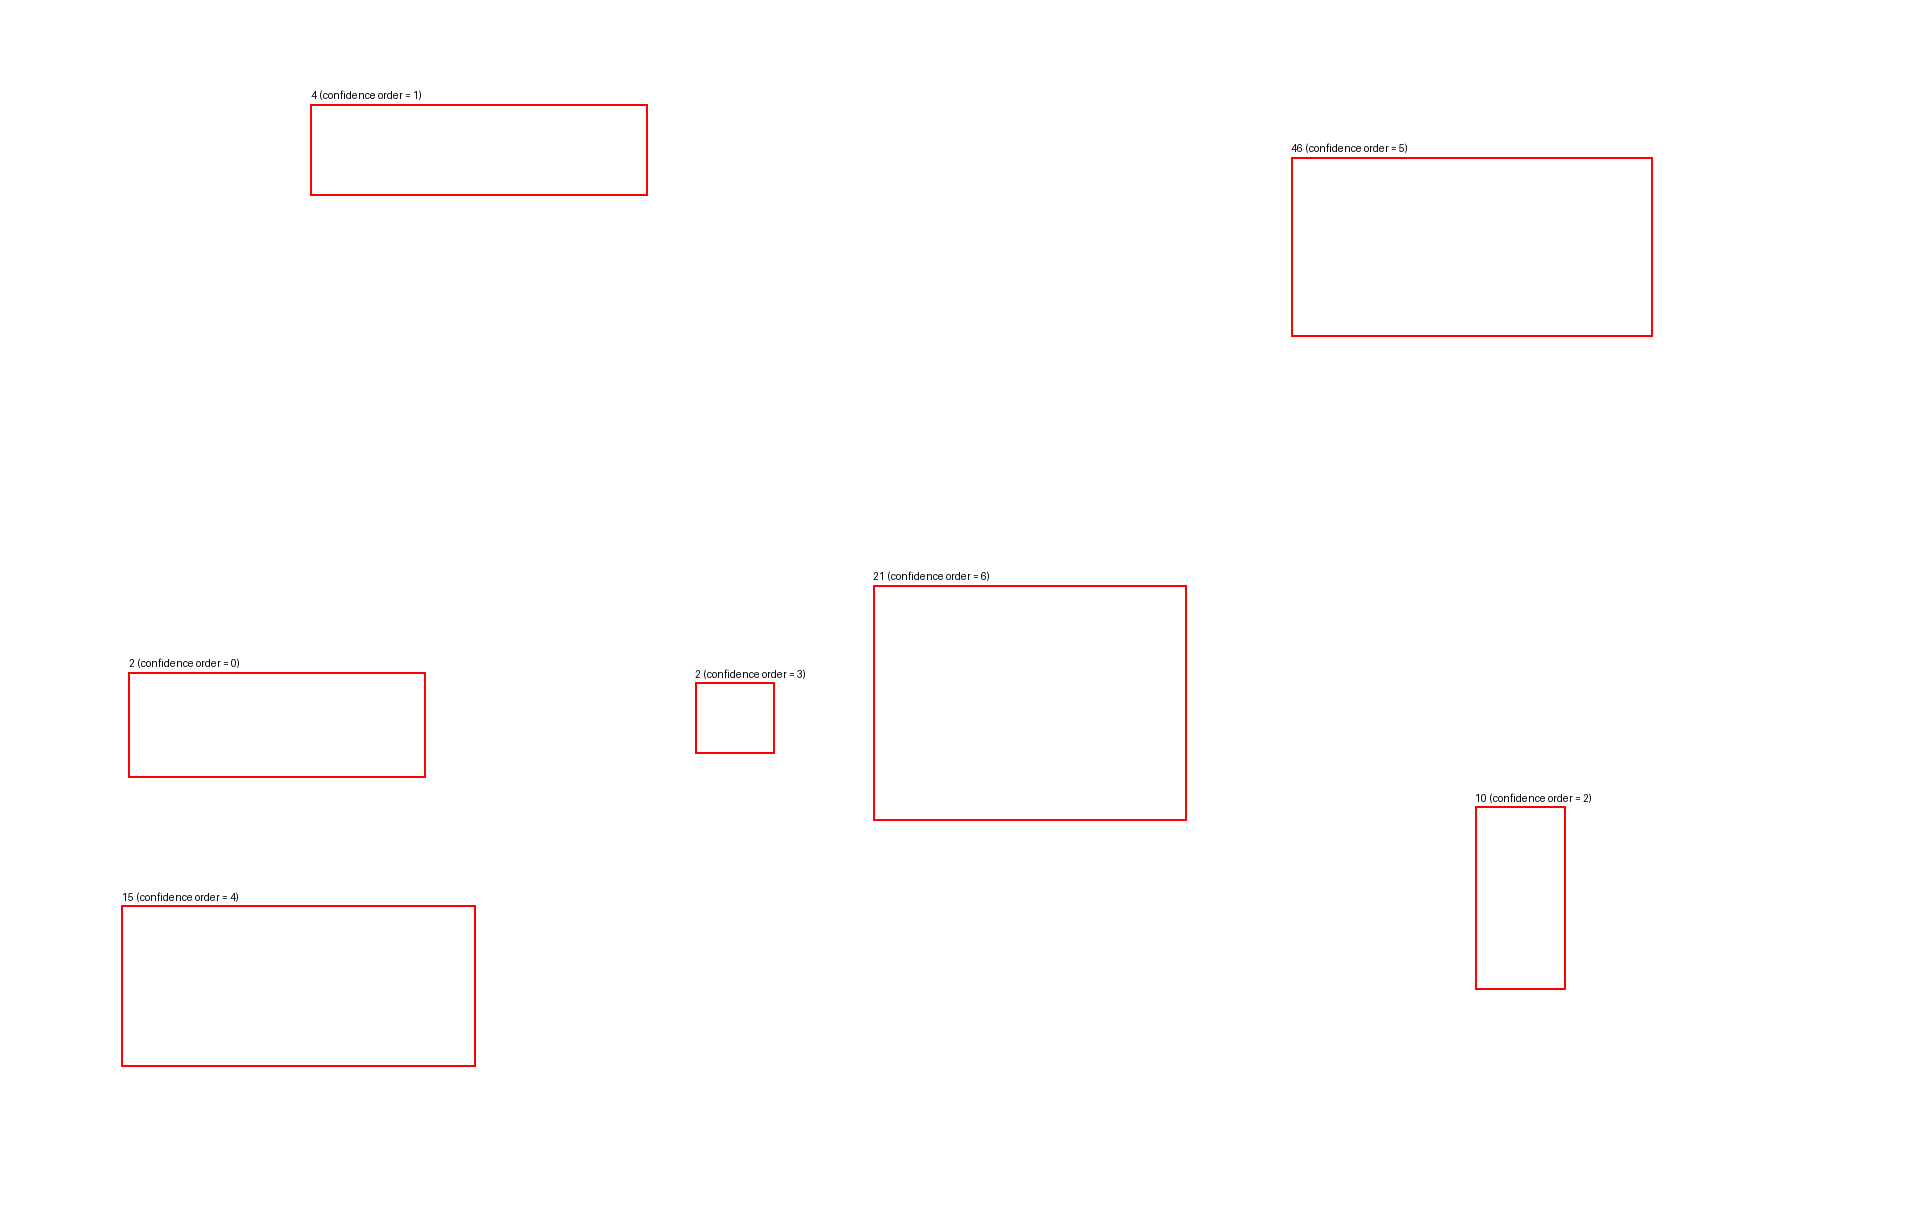

In [35]:
path_test = "./data/autopilot3_test.jpg"

preds_real = np.array(query_image(path_test, "autopilot1")["results"])
preds_diff = np.array([
    list(obj.values())
    for obj in query_image(path_test, "autopilot3")["distance"]
])
preds_flag = preds_real - preds_diff

image = Image.new("RGB", size=(1920, 1208), color="white")
draw = ImageDraw.Draw(image)
for i, (x0, y0, x1, y1, conf, class_) in enumerate(preds_flag):
    draw.rectangle((x0, y0, x1, y1), fill=None, outline="red", width=2)
    draw.text((x0, y0 - 15), f"{int(class_)} (confidence order = {i})", fill="black")
image

The classes we need in our image, in order of most confident to least confident, are `car`, `airplane`, `fire hydrant`, `car`, `cat`, `banana`, `bear`.

Through **a lot** of trial and error we were able to create the following image to get the flag.

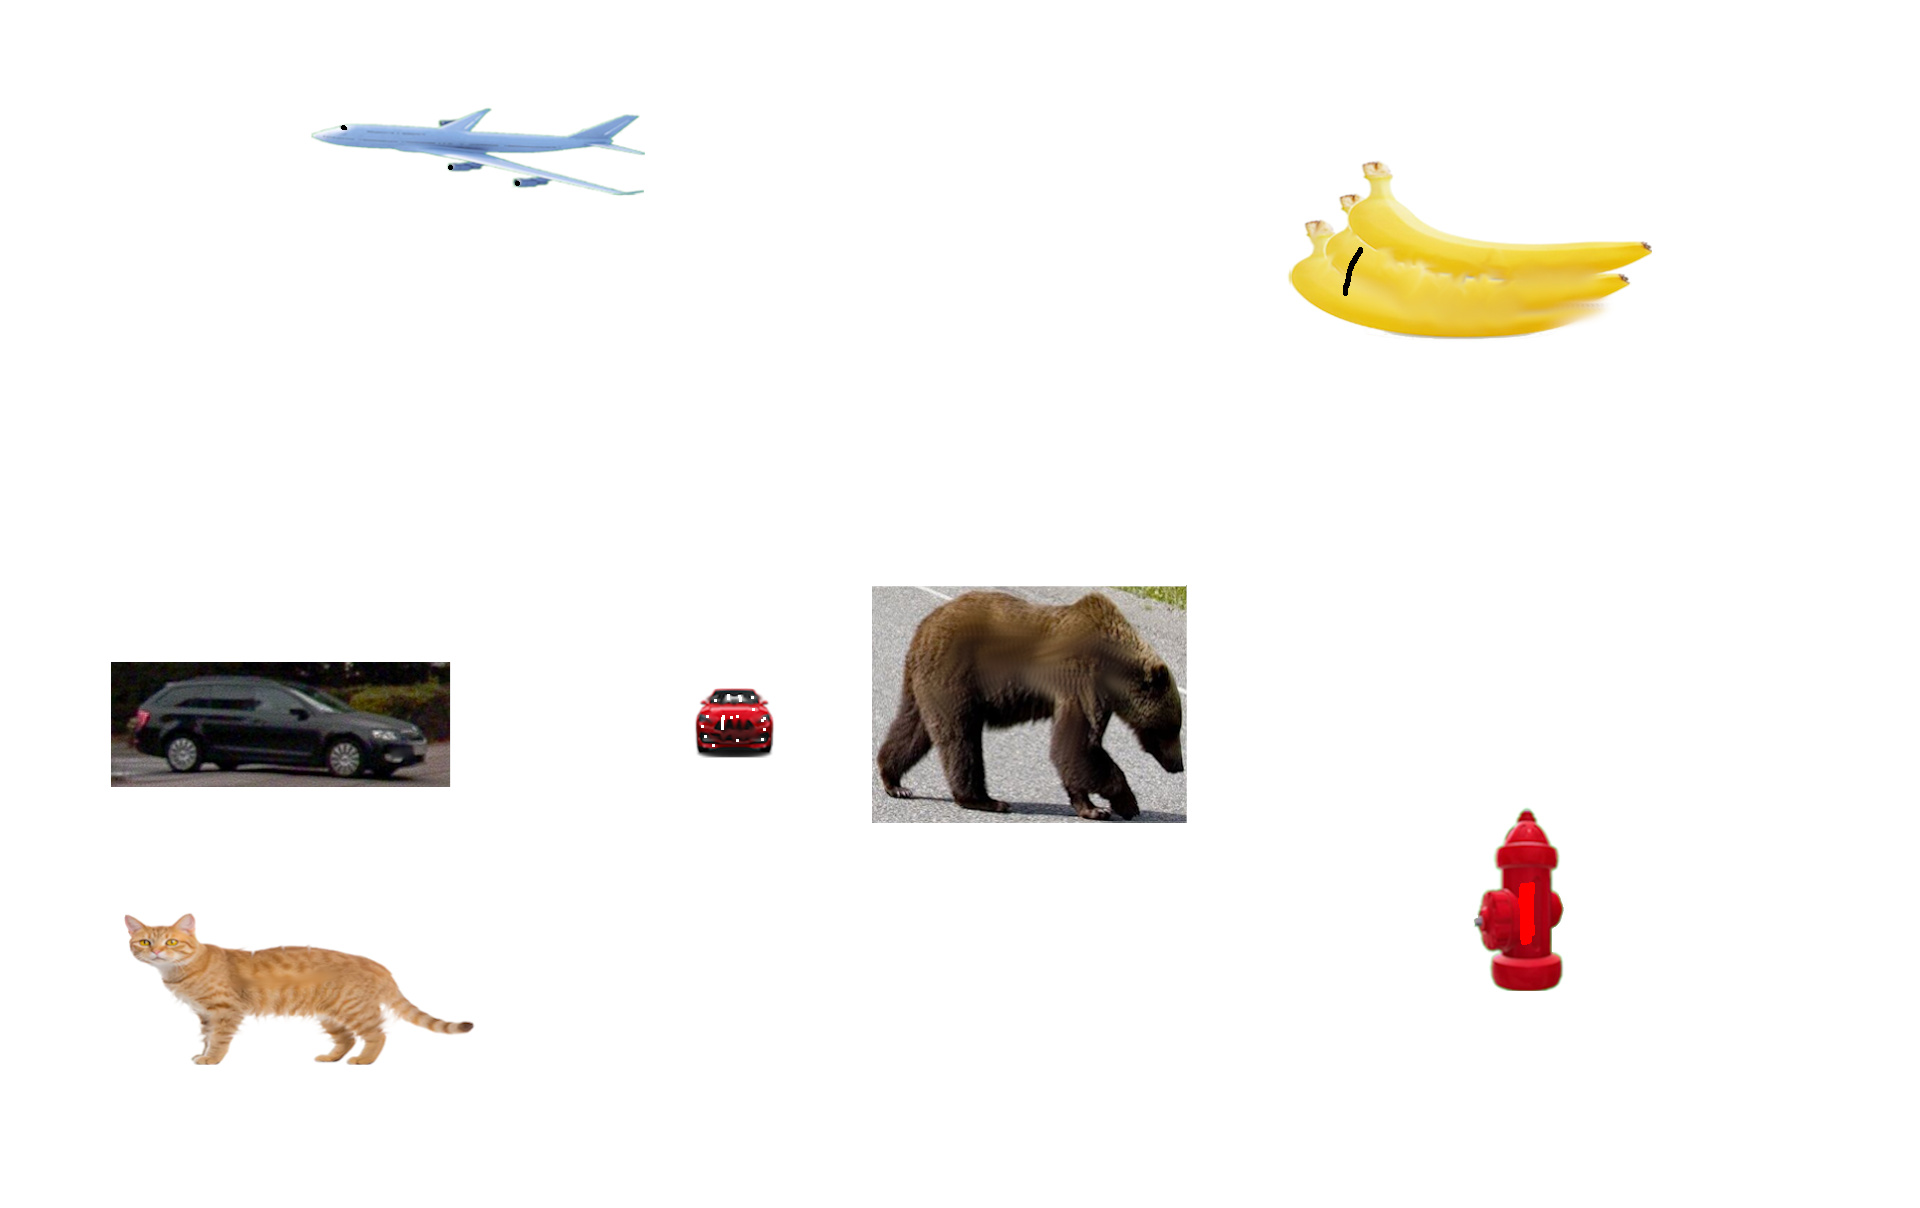

In [36]:
path_flag = "./data/autopilot3_flag.jpg"

Image.open(path_flag)

In [38]:
response = query_image(path_flag, "autopilot3")
print("Flag accepted:", submit(response["flag"]))

Flag accepted: True
